## Plot with Open Parks data

Year 2017 → missing prevalence for these areanm(s):
   • City of London
   • Isles of Scilly
Year 2018 → missing prevalence for these areanm(s):
   • City of London
   • Isles of Scilly
Year 2019 → missing prevalence for these areanm(s):
   • City of London
   • Isles of Scilly
Year 2020 → missing prevalence for these areanm(s):
   • City of London
   • Isles of Scilly
Year 2021 → missing prevalence for these areanm(s):
   • City of London
   • Isles of Scilly
Year 2022 → missing prevalence for these areanm(s):
   • City of London
   • Isles of Scilly


/tmp/ipykernel_416045/741401013.py:109: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("YlOrRd")
/tmp/ipykernel_416045/741401013.py:207: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=0.5)


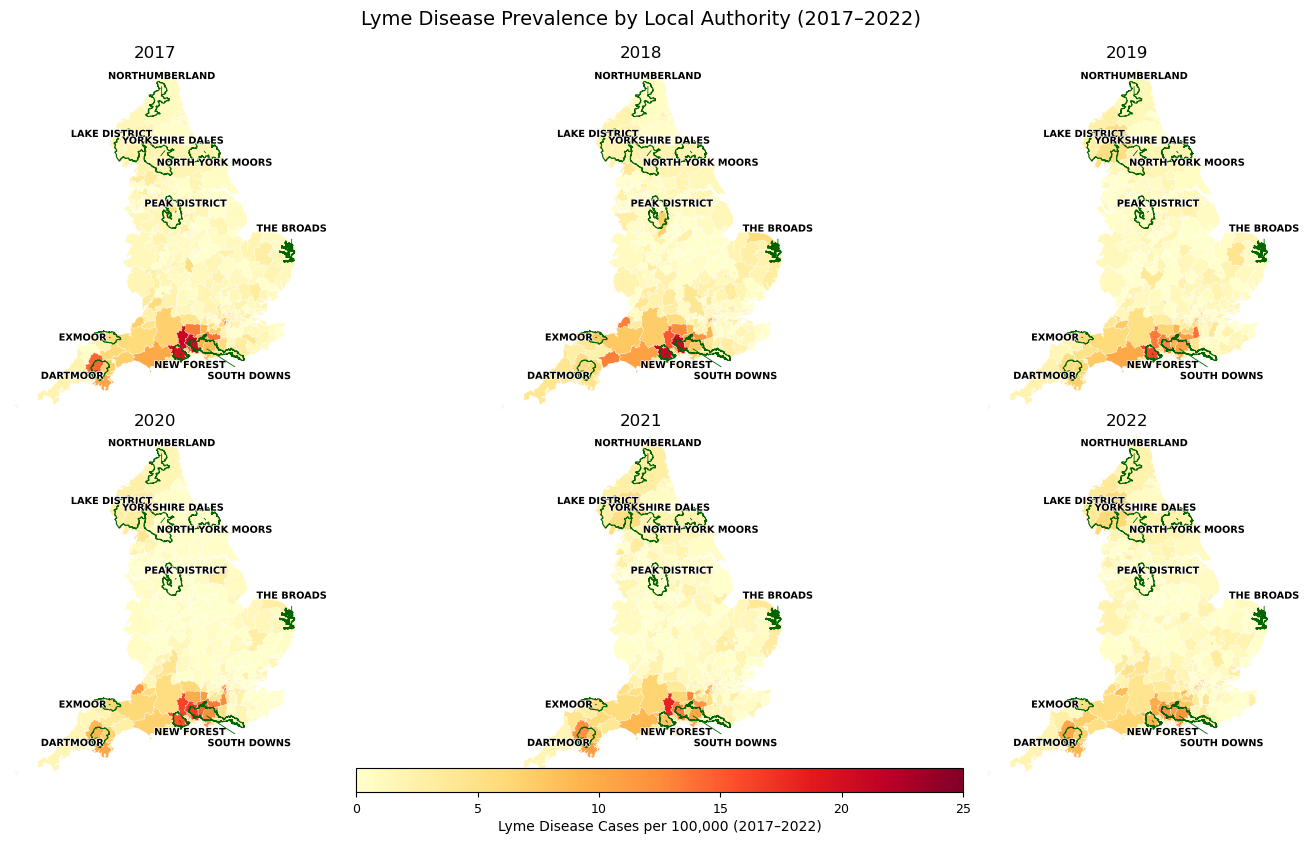

In [4]:
import os
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe

# --------------------------------------------------------------------------------
# 0) Ensure PROJ_DATA is set (only needed if you run into PROJ warning messages)
os.environ["PROJ_DATA"] = "/path/to/miniconda3/envs/hfc_lyme/share/proj"
# --------------------------------------------------------------------------------

# 1) Read in the forecast list of councils (so we can filter boundaries)
forecast = pd.read_csv("forecast.csv")  # must contain “Council” column

# 2) Load and filter the UK LAD (Local Authority District) boundaries once
geojson_url = "data/ltla.geojson"
gdf_boundaries = gpd.read_file(geojson_url)

# Keep only those councils listed in forecast["Council"]
gdf_boundaries = gdf_boundaries.loc[
    gdf_boundaries["areanm"].isin(forecast["Council"])
].to_crs("EPSG:4326")

# Compute a small buffer so that all subplots share identical xlim/ylim
minx, miny, maxx, maxy = gdf_boundaries.total_bounds
buffer = 0.1
xmin_plot, xmax_plot = minx - buffer, maxx + buffer
ymin_plot, ymax_plot = miny - buffer, maxy + buffer

# 3) Read in the parks GeoDataFrame once, and define label offsets
parks_gdf = gpd.read_file("data/National_Parks_England_4829975525583709119.geojson")
parks_gdf = parks_gdf.to_crs("EPSG:4326")

label_offsets = {
    "NORTHUMBERLAND":    ( 0.00,  0.40),
    "LAKE DISTRICT":     (-0.50,  0.20),
    "YORKSHIRE DALES":   ( 0.40,  0.30),
    "NORTH YORK MOORS":  ( 0.30, -0.20),
    "PEAK DISTRICT":     ( 0.30,  0.15),
    "EXMOOR":            (-0.80,  0.00),
    "DARTMOOR":          (-0.80, -0.10),
    "NEW FOREST":        ( 0.30, -0.20),
    "SOUTH DOWNS":       ( 1.30, -0.50),
    "THE BROADS":        ( 0.00,  0.40),
}

# 4) Read in the full Lyme‐disease CSV once
dat = pd.read_csv("data/processed_data/FULL-UKHSA-2017-2022-Lyme-Disease.csv")
dat = dat.dropna(subset=["Value"])  # drop rows where “Value” is NaN
dat = dat[dat["Area Type"].isin(["UA", "District"])]  # keep only local authorities

# Keep only the columns we need
df = dat[[
    "Area Code", "areanm", "Area Type", "year",
    "Value", "Denominator", "Lower CI 95.0 limit", "Upper CI 95.0 limit"
]].copy()

# We will store each year’s merged GeoDataFrame in this dict:
gdf_merged_by_year = {}

# 5) Loop over years 2017–2022 to build a GeoDataFrame for each year
for year in range(2017, 2023):
    # a) Filter to the current year
    this_df = df[df["year"] == year].copy()
    
    # b) Treat “Value” as the prevalence for that year
    this_df["Prevalence"] = this_df["Value"]
    
    # c) Compute mean prevalence per “areanm” (just in case there are duplicates)
    df_agg = (
        this_df
        .groupby(["Area Code", "areanm"])["Prevalence"]
        .mean()
        .reset_index()
    )

    # d) Merge with the boundary GeoDataFrame (left‐join)
    gdf_merged = gdf_boundaries.merge(
        df_agg,
        on="areanm",
        how="left"
    )

    # e) Print out which Local Authorities ended up with no data this year
    missing_data = gdf_merged.loc[gdf_merged["Prevalence"].isna(), "areanm"].values
    if len(missing_data) > 0:
        print(f"Year {year} → missing prevalence for these areanm(s):")
        for nm in sorted(missing_data):
            print("   •", nm)
    else:
        print(f"Year {year} → no missing Local Authorities.")

    # f) Store this merged GeoDataFrame in the dict
    #    (Note: it already contains the “geometry” column from gdf_boundaries)
    gdf_merged_by_year[year] = gdf_merged


# 6) Now that we have gdf_merged_by_year, create a 2×3 subplot grid
fig, axes = plt.subplots(
    nrows=2,
    ncols=3,
    figsize=(15, 9),
    constrained_layout=False
)

# We want all panels to use the same color‐scale (0 → 25)
vmin, vmax = 0, 25
cmap = plt.cm.get_cmap("YlOrRd")
norm = plt.Normalize(vmin=vmin, vmax=vmax)

# 7) Loop over each year, plot its choropleth into the correct subplot
years = list(range(2017, 2023))
for idx, year in enumerate(years):
    row, col = divmod(idx, 3)
    ax = axes[row, col]
    
    # Retrieve that year’s GeoDataFrame
    gdf_plot = gdf_merged_by_year[year]
    
    # a) Plot the choropleth (no legend here; we will add a shared colorbar later)
    gdf_plot.plot(
        column="Prevalence",
        ax=ax,
        cmap=cmap,
        vmin=vmin,
        vmax=vmax,
        missing_kwds={"color": "lightgrey"},
        linewidth=0.2,
        edgecolor="white",
        legend=False
    )
    
    # b) Crop each panel to the same geographic extent
    ax.set_xlim(xmin_plot, xmax_plot)
    ax.set_ylim(ymin_plot, ymax_plot)
    
    # c) Overlay park boundaries (dark green lines)
    parks_gdf.boundary.plot(
        ax=ax,
        edgecolor="darkgreen",
        linewidth=0.8
    )
    
    # d) Annotate each park name (with its offset)
    for _, park in parks_gdf.iterrows():
        name = park["NAME"]
        repr_pt = park.geometry.representative_point()
        x0, y0 = repr_pt.x, repr_pt.y
        dx, dy = label_offsets.get(name, (0.0, 0.0))
        
        ax.annotate(
            text=name,
            xy=(x0, y0),
            xytext=(x0 + dx, y0 + dy),
            fontsize=7,
            fontweight="bold",
            color="black",
            ha="center",
            va="center",
            path_effects=[
                pe.Stroke(linewidth=1.0, foreground="white"),
                pe.Normal()
            ],
            arrowprops={
                "arrowstyle": "-",
                "lw": 0.6,
                "color": "darkgreen",
                "connectionstyle": "arc3,rad=0.0"
            }
        )
    
    # e) Title each subplot with the year, and hide axes
    ax.set_title(f"{year}", fontsize=12, pad=4)
    ax.set_axis_off()

# 8) Add a single shared horizontal colorbar at the bottom
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # dummy array for colorbar

cbar = fig.colorbar(
    sm,
    ax=axes.ravel().tolist(),
    orientation="horizontal",
    fraction=0.035,  # thickness of the colorbar
    pad=0.015,       # how far below the subplots the bar sits
    aspect=25
)
ticks = list(np.linspace(vmin, vmax, num=6, dtype=int))
cbar.set_ticks(ticks)
cbar.set_ticklabels([str(t) for t in ticks])
cbar.ax.tick_params(labelsize=9)
cbar.set_label(
    "Lyme Disease Cases per 100,000 (2017–2022)",
    fontsize=10,
    labelpad=3
)

# 9) Add a super‐title
plt.suptitle(
    "Lyme Disease Prevalence by Local Authority (2017–2022)",
    fontsize=14,
    y=0.98
)

# 10) Tweak spacing so there’s minimal whitespace between panels
plt.tight_layout(pad=0.5)
plt.subplots_adjust(
    left=0.02,    # shrink left margin
    right=0.98,   # shrink right margin
    top=0.92,     # leave room for suptitle
    bottom=0.12,  # bring colorbar closer
    wspace=0.04,  # horizontal gap between columns
    hspace=0.04   # vertical gap between rows
)

plt.show()


## Plot host transmission

In [ ]:
import os
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
import numpy as np

# Ensure PROJ_DATA is set if needed
os.environ["PROJ_DATA"] = "/path/to/miniconda3/envs/hfc_lyme/share/proj"

def get_host_counts(host, this_df_host, gdf_boundaries, year):
    """
    Given a DataFrame `this_df_host` (filtered to one year) with columns
    "Longitude (WGS84)" and "Latitude (WGS84)", plus a GeoDataFrame 
    `gdf_boundaries` (with “areanm” polygons in EPSG:4326), return a DataFrame
    ["areanm", "host_record_count", "year"].
    """
    if this_df_host.empty:
        return pd.DataFrame(columns=["areanm", f"{host}_record_count", "year"])

    # Ensure boundaries are in EPSG:4326
    gdf_boundaries = gdf_boundaries.to_crs("EPSG:4326")

    # Convert host‐points to a GeoDataFrame
    gdf_host_year = gpd.GeoDataFrame(
        this_df_host,
        geometry=gpd.points_from_xy(
            this_df_host["Longitude (WGS84)"],
            this_df_host["Latitude (WGS84)"]
        ),
        crs="EPSG:4326"
    )

    # Spatial join points → polygon “areanm”
    poly_simple = gdf_boundaries[["areanm", "geometry"]]
    joined = gpd.sjoin(
        gdf_host_year,
        poly_simple,
        how="left",
        predicate="within"
    )

    # Count points per areanm
    counts = (
        joined
        .groupby("areanm")
        .size()
        .reset_index(name=f"{host}_record_count")
    )
    counts["year"] = year
    return counts


hosts = [
    "roe_deer",
    "red_deer",
    "chinese_water_deer",
    "wood_mice",
    "bank_voles",
    "blackbird"
]

start_year = 2017
end_year = 2025

for host in hosts:

    # 1) Load host records
    df_host = pd.read_csv(
        f"data/transmission_host/{host}/records-2025-06-06.csv"
    )[["Longitude (WGS84)", "Latitude (WGS84)", "Start date"]].dropna()
    df_host["year"] = pd.to_datetime(df_host["Start date"]).dt.year

    # Restrict points to England‐bounding box
    df_host = df_host[
        (df_host["Longitude (WGS84)"] > -8) & (df_host["Longitude (WGS84)"] < 2) &
        (df_host["Latitude (WGS84)"] > 49) & (df_host["Latitude (WGS84)"] < 61)
    ]

    # 2) Load forecast list of councils
    forecast = pd.read_csv("forecast.csv")

    # 3) Load English LAD boundaries once
    gdf_boundaries = gpd.read_file("data/ltla.geojson")
    gdf_boundaries = gdf_boundaries[gdf_boundaries["areanm"].isin(forecast["Council"])]
    gdf_boundaries = gdf_boundaries.to_crs("EPSG:4326")

    # Compute bounding box + buffer to crop out Scotland
    minx, miny, maxx, maxy = gdf_boundaries.total_bounds
    buffer = 0.1
    xmin_plot, xmax_plot = minx - buffer, maxx + buffer
    ymin_plot, ymax_plot = miny - buffer, maxy + buffer

    # 4) Compute host counts for all years and stack into one DataFrame
    all_host_counts = []
    for yr in range(start_year, end_year):
        this_year_hosts = df_host[df_host["year"] == yr].copy()
        counts = get_host_counts(host, this_year_hosts, gdf_boundaries, yr)
        all_host_counts.append(counts)
    host_summary_df = pd.concat(all_host_counts, ignore_index=True)

    # set (areanm, year) that are not in host_summary_df to 0
    all_areanm_years = pd.MultiIndex.from_product(
        [gdf_boundaries["areanm"], range(start_year, end_year)],
        names=["areanm", "year"]
    )
    host_summary_df = host_summary_df.set_index(["areanm", "year"]).reindex(all_areanm_years, fill_value=0).reset_index()

    # Find a reasonable vmax for the colormap (e.g. the 98th percentile or absolute max)
    vmax_host = int(host_summary_df[f"{host}_record_count"].max())
    vmin_host = 0

    # 5) Load parks & label offsets
    parks_gdf = gpd.read_file("data/National_Parks_England_4829975525583709119.geojson")
    parks_gdf = parks_gdf.to_crs("EPSG:4326")
    # label_offsets = {
    #     "NORTHUMBERLAND":    ( 0.00,  0.25),
    #     "LAKE DISTRICT":     (-0.35,  0.12),
    #     "YORKSHIRE DALES":   ( 0.25,  0.18),
    #     "NORTH YORK MOORS":  ( 0.20, -0.12),
    #     "PEAK DISTRICT":     ( 0.25,  0.08),
    #     "EXMOOR":            (-0.30,  0.00),
    #     "DARTMOOR":          (-0.30, -0.05),
    #     "NEW FOREST":        ( 0.20, -0.12),
    #     "SOUTH DOWNS":       ( 0.25, -0.12),
    #     "THE BROADS":        ( 0.20,  0.00),
    # }

    # 6) Create a 2×3 grid of subplots (one panel per year)
    # years = list(range(2017, 2023))
    # fig, axes = plt.subplots(2, 3, figsize=(15, 9), constrained_layout=True)
    # # fig.subplots_adjust(
    # #     left=0.01,    # minimal left margin
    # #     right=0.99,   # minimal right margin
    # #     top=0.92,     # small top margin
    # #     bottom=0.06,  # minimal bottom margin (for colorbar)
    # #     wspace=0.01,  # tight column spacing
    # #     hspace=0.01   # tight row spacing
    # # )

    # for idx, year in enumerate(years):
    #     row, col = divmod(idx, 3)
    #     ax = axes[row, col]

    #     # a) Extract host counts for this year
    #     this_counts = host_summary_df[host_summary_df["year"] == year]
    #     # b) Merge counts into the boundary GeoDataFrame
    #     gdf_merged = gdf_boundaries.merge(
    #         this_counts[["areanm", f"{host}_record_count"]],
    #         on="areanm",
    #         how="left"
    #     )

    #     # c) Plot host_count choropleth on this axis
    #     gdf_merged.plot(
    #         column=f"{host}_record_count",
    #         ax=ax,
    #         cmap="YlOrRd",
    #         vmin=vmin_host,
    #         vmax=vmax_host,
    #         missing_kwds={"color": "lightgrey"},
    #         legend=False
    #     )

    #     # d) Crop the view to England‐only
    #     ax.set_xlim(xmin_plot, xmax_plot)
    #     ax.set_ylim(ymin_plot, ymax_plot)

    #     # e) Overlay parks (boundaries + labels)
    #     parks_gdf.boundary.plot(
    #         ax=ax,
    #         edgecolor="darkgreen",
    #         linewidth=0.8
    #     )
    #     # for _, park in parks_gdf.iterrows():
    #     #     name = park["NAME"]
    #     #     repr_pt = park.geometry.representative_point()
    #     #     x0, y0 = repr_pt.x, repr_pt.y
    #     #     dx, dy = label_offsets.get(name, (0.0, 0.0))
    #     #     x_text, y_text = x0 + dx, y0 + dy

    #     #     ax.annotate(
    #     #         text=name,
    #     #         xy=(x0, y0),
    #     #         xytext=(x_text, y_text),
    #     #         fontsize=7,
    #     #         fontweight="bold",
    #     #         color="white",
    #     #         ha="center",
    #     #         va="center",
    #     #         path_effects=[
    #     #             pe.Stroke(linewidth=1.0, foreground="black"),
    #     #             pe.Normal()
    #     #         ],
    #     #         arrowprops={
    #     #             "arrowstyle": "-",
    #     #             "lw": 0.6,
    #     #             "color": "darkgreen",
    #     #             "connectionstyle": "arc3,rad=0.0"
    #     #         }
    #     #     )

    #     # f) Title each panel by its year, then hide axes
    #     ax.set_title(f"{year}", fontsize=12, pad=4)
    #     ax.set_axis_off()

    # plt.tight_layout(pad=0.1)
    # # 7) Shared colorbar at bottom (host counts 0→vmax_host)
    # cmap = plt.cm.get_cmap("YlOrRd")
    # norm = plt.Normalize(vmin=vmin_host, vmax=vmax_host)
    # sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    # sm.set_array([])

    # cbar = fig.colorbar(
    #     sm,
    #     ax=axes.ravel().tolist(),
    #     orientation="horizontal",
    #     fraction=0.035,
    #     pad=0.015,
    #     aspect=25
    # )
    # # Choose tick locations at round numbers up to vmax_host
    # ticks = list(np.linspace(0, vmax_host, num=6, dtype=int))
    # cbar.set_ticks(ticks)
    # cbar.set_ticklabels([str(t) for t in ticks])
    # cbar.ax.tick_params(labelsize=9)
    # cbar.set_label(
    #     f"{host.replace('_', ' ').title()} Records per Area (2017–2022)",
    #     fontsize=10,
    #     labelpad=3
    # )

    # plt.suptitle(
    #     f"{host.replace('_', ' ').title()}: Host Counts by Local Authority (2017–2022)",
    #     fontsize=14,
    #     y=0.98
    # )
    
    # plt.show()
    # # save figure
    # plt.savefig(
    #     f"figures/{host}_host_counts_by_area.pdf",
    #     dpi=300,
    #     bbox_inches='tight'
    # )

    # 8) Save host counts summary for this species
    # drop duplicates 
    host_summary_df = host_summary_df.drop_duplicates(subset=["areanm", "year"])
    host_summary_df.to_csv(
        f"data/processed_data/{host}_counts_by_area.csv",
        index=False
    )


/tmp/ipykernel_416045/1871163266.py:69: DtypeWarning: Columns (30,31) have mixed types. Specify dtype option on import or set low_memory=False.
  df_host = pd.read_csv(


## Plot age demographics

These 'areanm' values were in your boundary GeoDataFrame but did NOT appear in df_age:


/tmp/ipykernel_418883/1854914194.py:61: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("YlOrRd")


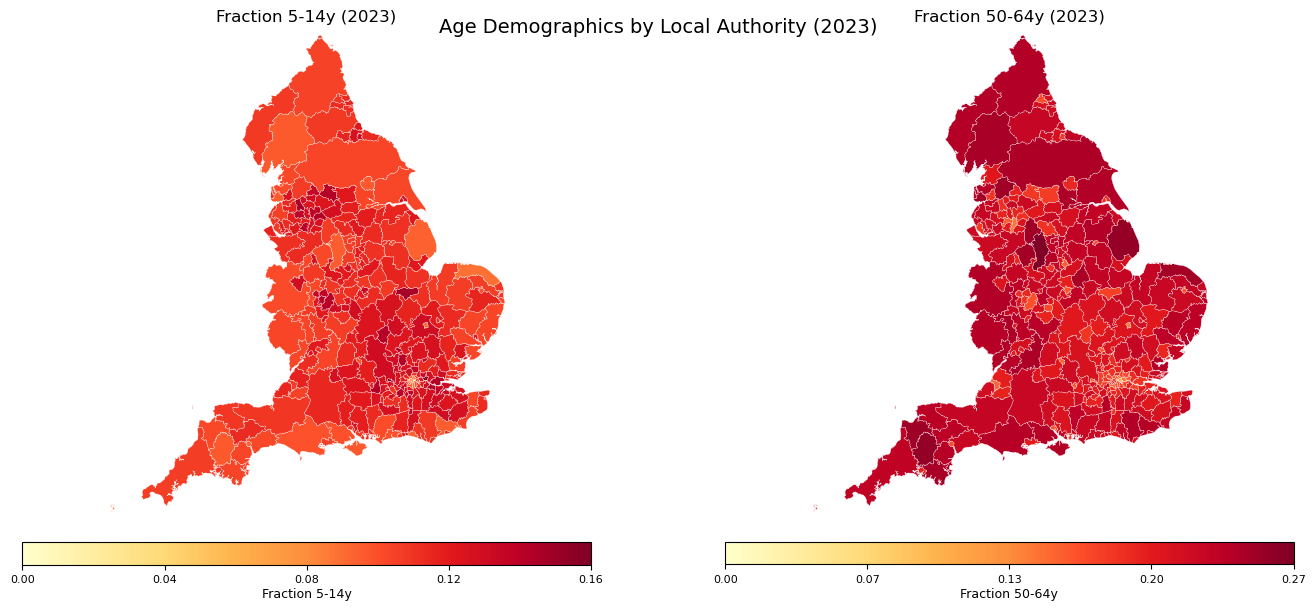

<Figure size 640x480 with 0 Axes>

In [1]:
import os
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np

# 1) Read in your age‐demographics CSV
df_age = pd.read_csv("data/processed_data/age_demographics_2023_fraction.csv")
# Make sure your CSV has at least these columns:
#    "areanm", "5_to_14y_fraction", "50_to_65y_fraction", …

# 2) Read the forecast list of councils (so we only plot the areas we care about)
forecast = pd.read_csv("../submission/forecast.csv")  # must contain a “Council” column

# 3) Load English LAD boundaries and filter to those councils
gdf_boundaries = gpd.read_file("data/ltla.geojson")
gdf_boundaries = (
    gdf_boundaries
    .loc[gdf_boundaries["areanm"].isin(forecast["Council"])]
    .to_crs("EPSG:4326")
)

# 4) Merge the age‐fraction columns onto the boundary GeoDataFrame
cols_to_keep = ["areanm", "5_to_14y_fraction", "50_to_65y_fraction"]
gdf_merged = gdf_boundaries.merge(
    df_age[cols_to_keep],
    on="areanm",
    how="left"
)

# 5) Find all the area names where the under_15_fraction is NaN
missing_areanms = (
    gdf_merged.loc[gdf_merged["5_to_14y_fraction"].isna(), "areanm"]
    .sort_values()
    .unique()
)

# 6) Print them out
print("These 'areanm' values were in your boundary GeoDataFrame but did NOT appear in df_age:")
for a in missing_areanms:
    print(f"  • {a}")
    
# 5) Compute two separate color‐scale ranges (vmin/vmax) for each fraction
#    (In this example we force vmin = 0 for both, but each subplot gets its own vmax.)
vmin_15 = 0.0
vmax_15 = gdf_merged["5_to_14y_fraction"].max()

vmin_50 = 0.0
vmax_50 = gdf_merged["50_to_65y_fraction"].max()

# 6) Compute a common bounding box (with a tiny buffer) so both maps have identical extents
minx, miny, maxx, maxy = gdf_merged.total_bounds
buffer = 0.1
xmin_plot, xmax_plot = minx - buffer, maxx + buffer
ymin_plot, ymax_plot = miny - buffer, maxy + buffer

# 7) Create a 1×2 subplot grid
fig, axes = plt.subplots(1, 2, figsize=(14, 6), constrained_layout=True)

# Choose a colormap name (e.g. "YlOrRd")
cmap = plt.cm.get_cmap("YlOrRd")

# ---- Panel 1: Fraction Under 15 ----
ax0 = axes[0]
gdf_merged.plot(
    column="5_to_14y_fraction",
    ax=ax0,
    cmap=cmap,
    vmin=vmin_15,
    vmax=vmax_15,
    missing_kwds={"color": "lightgrey"},  # no‐data areas
    linewidth=0.2,
    edgecolor="white",
    legend=False
)
ax0.set_title("Fraction 5-14y (2023)", fontsize=12, pad=4)
ax0.set_xlim(xmin_plot, xmax_plot)
ax0.set_ylim(ymin_plot, ymax_plot)
ax0.set_axis_off()

# Create an independent ScalarMappable for “under 15”:
sm_15 = plt.cm.ScalarMappable(
    cmap=cmap,
    norm=plt.Normalize(vmin=vmin_15, vmax=vmax_15)
)
sm_15.set_array([])  # only needed so colorbar knows the range

cbar_15 = fig.colorbar(
    sm_15,
    ax=ax0,
    orientation="horizontal",
    fraction=0.046,  # controls the colorbar thickness
    pad=0.04,        # vertical padding between map and colorbar
    aspect=25
)
cbar_15.set_label("Fraction 5-14y", fontsize=9, labelpad=2)
ticks_15 = np.linspace(vmin_15, vmax_15, num=5)
cbar_15.set_ticks(ticks_15)
cbar_15.set_ticklabels([f"{t:.2f}" for t in ticks_15])
cbar_15.ax.tick_params(labelsize=8)


# ---- Panel 2: Fraction Over 50 ----
ax1 = axes[1]
gdf_merged.plot(
    column="50_to_65y_fraction",
    ax=ax1,
    cmap=cmap,
    vmin=vmin_50,
    vmax=vmax_50,
    missing_kwds={"color": "lightgrey"},
    linewidth=0.2,
    edgecolor="white",
    legend=False
)
ax1.set_title("Fraction 50-64y (2023)", fontsize=12, pad=4)
ax1.set_xlim(xmin_plot, xmax_plot)
ax1.set_ylim(ymin_plot, ymax_plot)
ax1.set_axis_off()

# Create an independent ScalarMappable for “over 50”:
sm_50 = plt.cm.ScalarMappable(
    cmap=cmap,
    norm=plt.Normalize(vmin=vmin_50, vmax=vmax_50)
)
sm_50.set_array([])

cbar_50 = fig.colorbar(
    sm_50,
    ax=ax1,
    orientation="horizontal",
    fraction=0.046,
    pad=0.04,
    aspect=25
)
cbar_50.set_label("Fraction 50-64y", fontsize=9, labelpad=2)
ticks_50 = np.linspace(vmin_50, vmax_50, num=5)
cbar_50.set_ticks(ticks_50)
cbar_50.set_ticklabels([f"{t:.2f}" for t in ticks_50])
cbar_50.ax.tick_params(labelsize=8)


# 8) (Optional) Add a shared super‐title
fig.suptitle("Age Demographics by Local Authority (2023)", fontsize=14, y=0.98)

plt.show()
plt.savefig("figures/age_demographics_map.pdf", dpi=300, bbox_inches='tight')


## Explainability

In [3]:
import json
from pathlib import Path
import pandas as pd

# --- CONFIG ------------------------------------------------------------
RESULTS_DIR = Path("results")
OUTPUT_CSV  = "model_top_features.csv"
TOP_K       = 120   # how many top features to keep

# --- HELPERS -----------------------------------------------------------
def gather_jsons(results_dir):
    """
    Returns a dict mapping model_name -> list of json file paths.
    Assumes your JSONs live in folders like results/<model>_<seed>/..._results.json
    """
    js = {}
    for p in results_dir.rglob("*.json"):
        # e.g. p = results/ xgboost_0 / xgboost_results.json
        model_folder = p.parts[1]           # e.g. "xgboost_0"
        model_name   = model_folder.split("_")[0]
        js.setdefault(model_name, []).append(p)
    return js

# --- MAIN --------------------------------------------------------------
def main():
    # 1) Find all JSONs
    model_jsons = gather_jsons(RESULTS_DIR)

    rows = []
    for model, paths in model_jsons.items():
        # 2) Load each JSON's feature_importance into a Series
        dfs = []
        for fp in paths:
            data = json.loads(fp.read_text())
            imp  = data.get("feature_importance") or data.get("kernel_scales")
            # if some use a different key, you can handle that here
            s    = pd.Series(imp, name=fp.stem)
            dfs.append(s)

        # 3) Combine into a DataFrame
        imp_df = pd.concat(dfs, axis=1).fillna(0)

        # 4) Compute the mean importance across seeds
        mean_imp = imp_df.mean(axis=1)

        # 5) Get top-K features
        top_feats = list(mean_imp.sort_values(ascending=False).index[:TOP_K])

        # 6) Build the row dict
        row = {"Model": model}
        for i, feat in enumerate(top_feats, start=1):
            # row[f"top{i}"] = feat
            score = mean_imp.loc[feat]
            row[f"top{i}"] = f"{feat}:{score:.4f}"
        rows.append(row)

    # 7) Dump to CSV
    out_df = pd.DataFrame(rows).sort_values("Model")
    out_df.to_csv(OUTPUT_CSV, index=False)
    print(f"Wrote top-{TOP_K} features per model to {OUTPUT_CSV}")

if __name__ == "__main__":
    main()


Wrote top-120 features per model to model_top_features.csv


/tmp/ipykernel_1880763/3157981144.py:41: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  imp_df = pd.concat(dfs, axis=1).fillna(0)
